In this class, we will talk about model explainability but more in the context of data explainability or root cause analysis. In many cases building a very good machine learning model is not an ultimate goal. What is really wanted is the data understanding. A factory wants to know why the product is plagued with a defect, not to predict afterward if there is a defect or not. A football team wants to know which position is the best for scoring a goal, not what's the probability of scoring from a given position. And even when they want a prediction they would love to see the justification to trust the model. Often a nice plot is worth more than sophisticated machine-learning approaches.

In [166]:
import pandas as pd
import numpy as np
import dalex as dx #library for model explainability
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_wine
from sklearn_extra.cluster import KMedoids

In [167]:
data = load_wine()

In [168]:
data
df = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']
df['target'] = y

In [169]:
df.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0                          3.92   1065.0       0  
1                          3.40   1050.0       0  
2                          3.17   1185.0       0  
3                          3.45   1480.0       0  
4                          2.93    735.0       0

You should already be familiar with many data visualization techniques so we will not train it now. I just want to share a less popular type of data analysis. Usually plotting the target against any feature is not helpful but after some modification, we might be able to see some patterns.

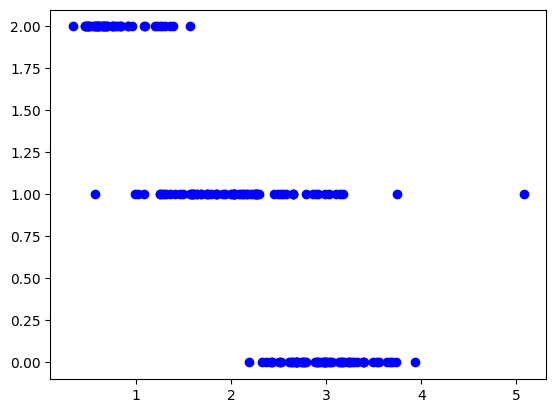

In [170]:
plt.plot(df.flavanoids, y, 'bo')
# bo -> blue circles

For each value, we can plot the average target for data:
 - below that value
 - above that value
 - around that value

Please note that for the line "above that value" the more left we go the higher fraction of data is covered. The same with the "below that value"

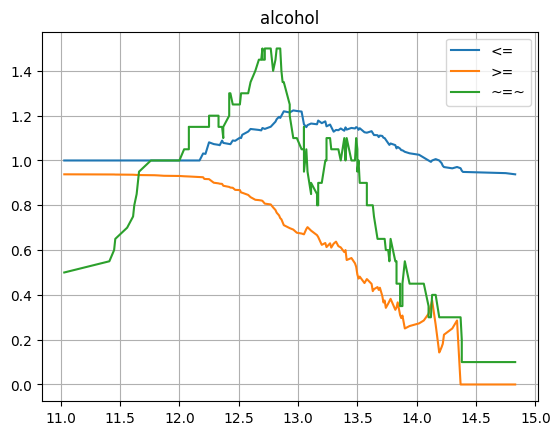

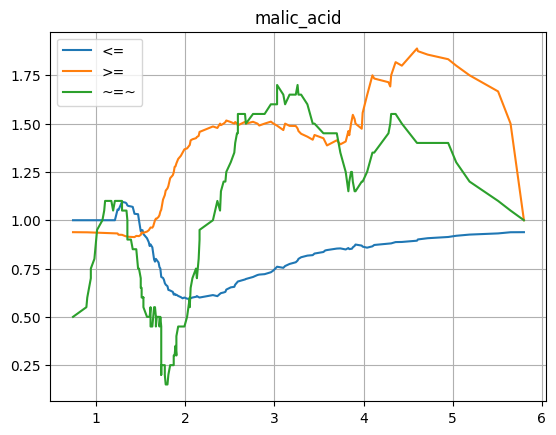

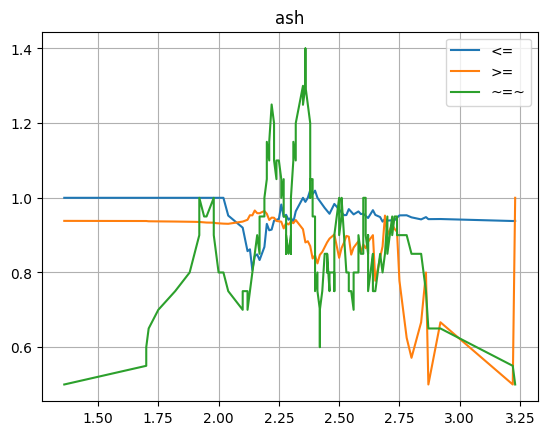

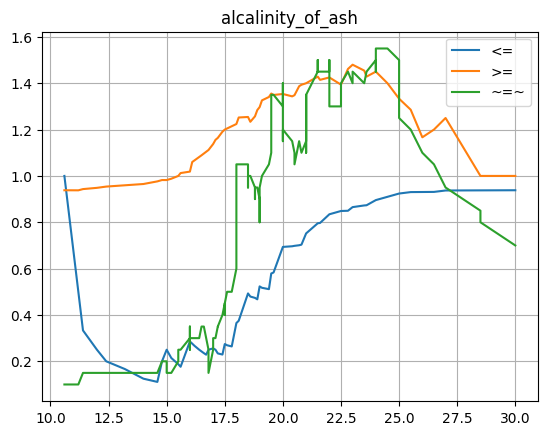

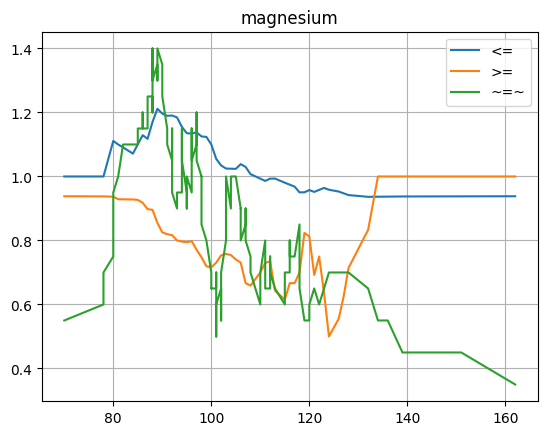

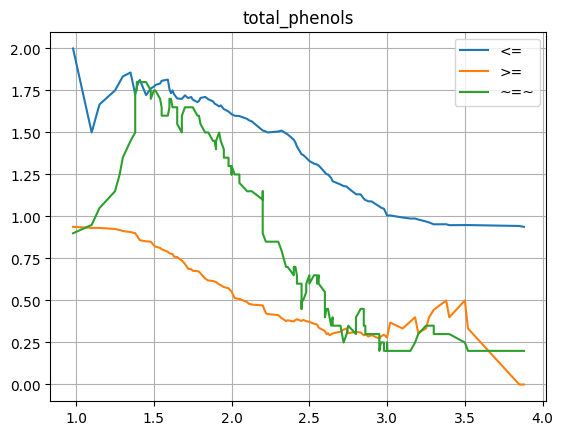

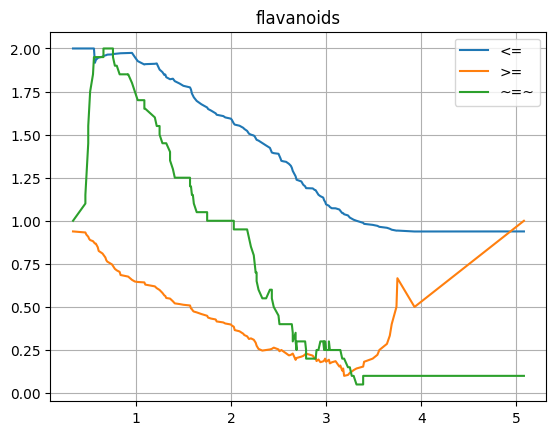

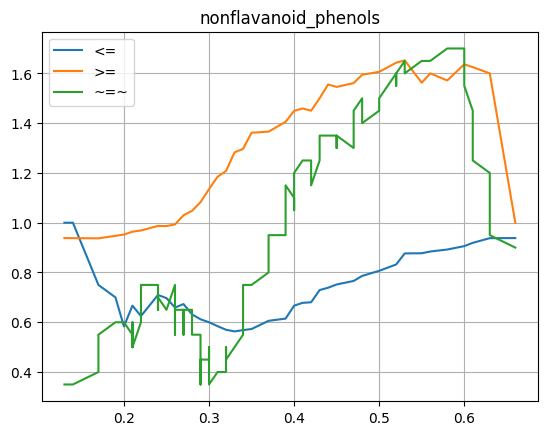

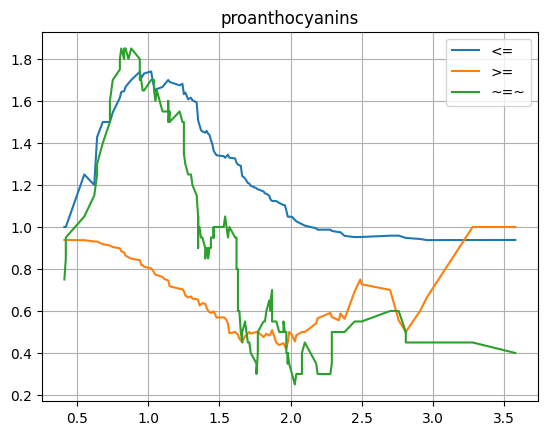

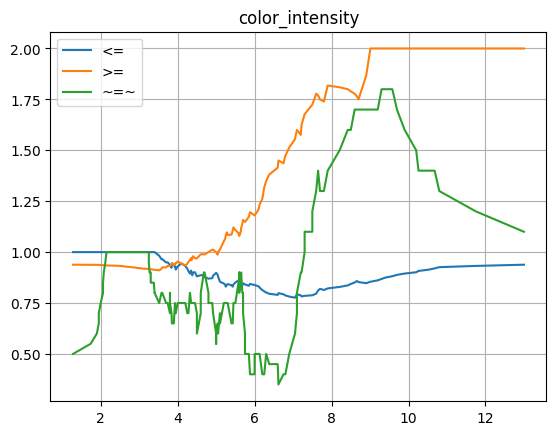

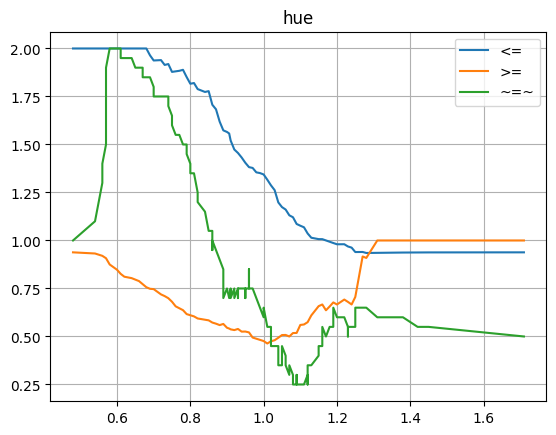

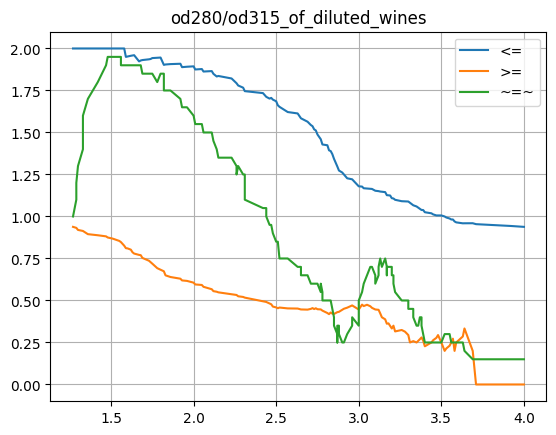

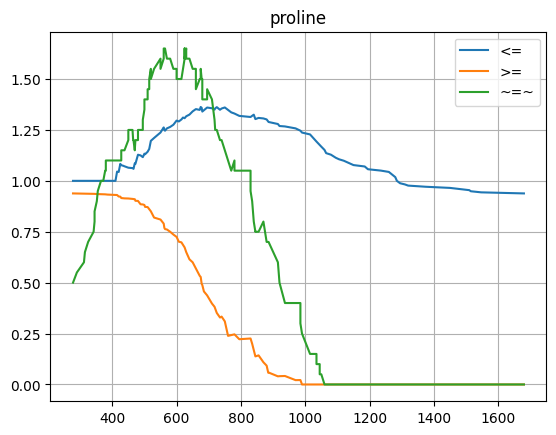

In [171]:
for col in df.columns.drop('target'):
    tmp = df.sort_values(col)
    plt.title(col)
    plt.plot(tmp[col], tmp[col].apply(lambda x: tmp[tmp[col] <= x].target.mean()), label="<=")
    plt.plot(tmp[col], tmp[col].apply(lambda x: tmp[tmp[col] >= x].target.mean()), label=">=")
    plt.plot(tmp[col], np.convolve(np.ones(20)/20, tmp.target, mode='same'), label= "~=~")
    plt.legend()
    plt.grid()
    plt.show()

Ok, let's just train a model. We are not interested in top performance right now so we will skip hyperparameter optimization. Also, we want to find the pattern in the data we have, so we don't split the data into validation and test set.

In [172]:
model = RandomForestRegressor()
x = df.drop('target', axis=1)
y = df.target
model.fit(x, y)

RandomForestRegressor()

In [173]:
model

RandomForestRegressor()

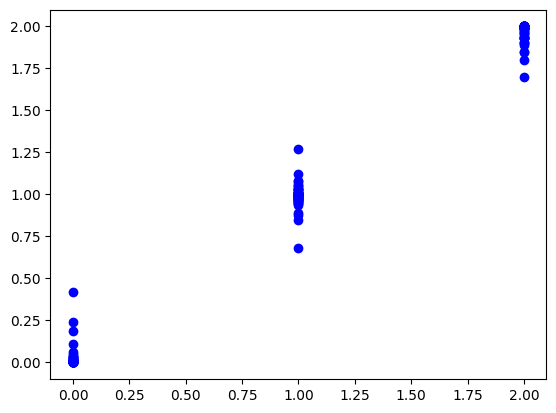

In [174]:
plt.plot(df.target, model.predict(x), 'bo')

Dalex is a python package for model explainability. We will use some of its functions to understand the data and the model better. First, we need to create an explainer model. Since we are not interested in checking the model performance but the relation between the data and the target we will use the whole dataset here. In the first case, we might want to use the testing set.

In [175]:
exp = dx.Explainer(model, x, y)

Preparation of a new explainer is initiated

  -> data              : 178 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 178 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x0000019B369901F0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.933, max = 2.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.42, mean = 0.00483, max = 0.32
  -> model_info        : package sklearn

A new explainer has been created!


In [176]:
fi = exp.model_parts()

exp.model_parts() computes the importance of each feature by measuring how much the model's performance degrades when each feature is shuffled (permuted). This is known as Permutation Feature Importance.

In [177]:
fi

The dropout_loss is a measure of how much the model's performance decreases when a particular feature is shuffled.

-Higher dropout_loss indicates that when a feature is shuffled, it has a significant negative impact on the model's performance, suggesting that the feature is highly important to the model's predictions. <br>
-Lower dropout_loss suggests that shuffling that feature does not significantly change the model's performance, indicating that the feature is not as crucial for the model.

The first step will be feature importance. It's a basic analysis where we calculate the global impact of a feature. The idea in dalex default approach is to measure **how much the model performance is worsening after removing this feature**. Of course, it would require retraining the model, the optimal set of hyperparameters might be different and it might affect the results. To avoid these problems **we do not retrain the model**. Instead, **we simulate its removal by assigning random values to it**. To make it more realistic **the values are not completely random, we just shuffle this column in a dataframe**, do the prediction, check performance and repeat these steps multiple times.

In [178]:
fi.plot()

Another useful tool is a partial dependency plot. For a given feature we observe what's the average output of our model for different values of this feature. For each considered value we set this value for each row in our dataframe and calculate an average prediction.

*A Partial Dependence Plot (PDP) shows how changing one feature affects the model's predictions, on average. It changes the feature's value across all data points and calculates the average prediction for each value.* <br>
*A straighter line in a Partial Dependence Plot (PDP) means that changes in that feature have little effect on the model’s predictions, indicating the feature has a smaller impact on the outcome.*

In [179]:
exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 13/13 [00:00<00:00, 30.02it/s]



We can also create similar plots for single rows. Here for each column, we present what would be the output from the model assuming we keep all remaining values and change the value of this one selected feature.

In [180]:
df.iloc[15]

alcohol                           13.63
malic_acid                         1.81
ash                                2.70
alcalinity_of_ash                 17.20
magnesium                        112.00
total_phenols                      2.85
flavanoids                         2.91
nonflavanoid_phenols               0.30
proanthocyanins                    1.46
color_intensity                    7.30
hue                                1.28
od280/od315_of_diluted_wines       2.88
proline                         1310.00
target                             0.00
Name: 15, dtype: float64

In [181]:
exp.predict_profile(x.iloc[[15,80]]).plot()

Calculating ceteris paribus: 100%|██████████| 13/13 [00:00<00:00, 160.37it/s]


SHAP values are equivalents of Shapley values for the predictive models. It estimates the effect of a particular value of a particular feature for a prediction of a considered row. It's also done by replacing this value with proper sampling and replacing this value and measuring the effect on the prediction.

In [182]:
exp.predict_parts(x.iloc[15], type='shap').plot()

In [183]:
x.iloc[15]

alcohol                           13.63
malic_acid                         1.81
ash                                2.70
alcalinity_of_ash                 17.20
magnesium                        112.00
total_phenols                      2.85
flavanoids                         2.91
nonflavanoid_phenols               0.30
proanthocyanins                    1.46
color_intensity                    7.30
hue                                1.28
od280/od315_of_diluted_wines       2.88
proline                         1310.00
Name: 15, dtype: float64

In [184]:
exp.predict_parts(x.iloc[15], type='shap').plot()

In [185]:
exp.predict_parts(x.iloc[80], type='shap').plot()

The result is based on sampling so the result for the same row can vary

In [186]:
exp.predict_parts(x.iloc[88], type='shap').plot()

In [187]:
exp.predict_parts(x.iloc[88], type='shap').result

variable  contribution  \
0   od280/od315_of_diluted_wines = 2.75     -0.053989   
1                proanthocyanins = 1.35     -0.003876   
2                             hue = 1.0     -0.022079   
3                     flavanoids = 1.69     -0.065843   
4                            ash = 2.46     -0.001348   
..                                  ...           ...   
8                proanthocyanins = 1.35     -0.002560   
9                     malic_acid = 2.06      0.001142   
10                 total_phenols = 1.95     -0.000645   
11                           ash = 2.46      0.000528   
12          nonflavanoid_phenols = 0.48      0.000211   

                   variable_name  variable_value  sign                  label  \
0   od280/od315_of_diluted_wines            2.75  -1.0  RandomForestRegressor   
1                proanthocyanins            1.35  -1.0  RandomForestRegressor   
2                            hue            1.00  -1.0  RandomForestRegressor   
3                     flavanoids            1.69  -1.0  RandomForestRegressor   
4                            ash            2.46  -1.0  RandomForestRegressor   
..                           ...             ...   ...                    ...   
8                proanthocyanins            1.35  -1.0  RandomForestRegressor   
9                     malic_acid            2.06   1.0  RandomForestRegressor   
10                 total_phenols            1.95  -1.0  RandomForestRegressor   
11                           ash            2.46   1.0  RandomForestRegressor   
12          nonflavanoid_phenols            0.48   1.0  RandomForestRegressor   

    B  
0   1  
1   1  
2   1  
3   1  
4   1  
.. ..  
8   0  
9   0  
10  0  
11  0  
12  0  

[338 rows x 7 columns]

**Task** For each class find the most representative examples and plot breakdown for them.

Imagine we have a model classifying dogs and cats. Then a good example would be to show e.g. 3 breeds of dogs and the same with cats. Showing 5 golden retrievers although cute is not the best approach.

There isn't a single best way how to approach this task. There are many good solutions. Think about what you want to achieve and then how to do it

In [188]:
def find_representants(df, number_of_clusters, pipeline=None):
    representative_samples = {}
    if pipeline:
        preprocessor = pipeline.named_steps['preprocessor']
        
    for wine_type in df['target'].unique():
        samples = df[df['target'] == wine_type].drop('target', axis = 1) #we leave only teh observations that are type that we want (0,1 or 2) 
        original_id = samples.index
        #and then drop the target column 
        if pipeline:
            samples = preprocessor.transform(samples)
        kmedoids = KMedoids(n_clusters=number_of_clusters, random_state=106)
        kmedoids.fit(samples)
        medoid_id = kmedoids.medoid_indices_
        
        representative_samples[wine_type] = original_id[medoid_id].tolist()
    return representative_samples
        


In [189]:
representative_samples = find_representants(df, number_of_clusters=3)
print(representative_samples)

{0: [48, 58, 25], 1: [109, 116, 125], 2: [142, 141, 148]}


In [190]:
representative_samples = find_representants(df, number_of_clusters=3)
#number_of_graphs = len(sample)
number_of_graphs = 3
for wine_type, sample_id in representative_samples.items():
    print(f"Representative sample for wine type {wine_type}: {sample_id}")
    for i in range(0, number_of_graphs):
        exp.predict_parts(x.iloc[sample_id[i]], type='shap').plot()
    #print("Data about the sample:")
    #print(df.iloc[sample])
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

Representative sample for wine type 0: [48, 58, 25]


----------------------------------------------------------------------------------------------------------------------------------------------
Representative sample for wine type 1: [109, 116, 125]


----------------------------------------------------------------------------------------------------------------------------------------------
Representative sample for wine type 2: [142, 141, 148]


----------------------------------------------------------------------------------------------------------------------------------------------


There are other approaches that can be used for model explainability.
 - LIME - approximating model locally by a linear model
 - Anchor - approximating model locally by a rule-based model
 - Prototype - justifying a new prediction by showing a similar example from the data (a prototype)
 - Counterfactual Explanation - showing a similar exmaple from the dataset with a different prediction to show what must be changed to change the prediction.

# Task

- take a dataset you want
- perform an exploratory data analysis (data visualization)
- create a sklearn pipeline for data preprocessing
- add new features (one hot encoding for example)
- add predictive model as the last step of the pipeline
- prepare a report with model explainability

Send it to gmiebs@cs.put.poznan.pl within 144 hours after the class is finished. Start the subject of the email with [IR]

Assume your report will be read by a domain expert from the area of the data, in our case a wine expert, without any computer science / data science skills. It means the person will not get much from raw plots and diagrams. Everything has to be explained to be understood.

---------------------------

<h3>Team:</h3>
 - Martyna Stasiak id.156071
 - Maria Musiał id.156062

---------------------

<h3>Libraries needed for the task

In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
#import shap
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

<h3>Understanding Dataset</h3>
<h4> For this tak we have chosen the dataset called <i>Student performance</i><br></h4>
Source: <a href="https://www.kaggle.com/datasets/larsen0966/student-performance-data-set">Link to the dataset</a><br>

---------------------

This dataset contains information about student achievement in secondary education at two Portuguese schools, focusing on student grades and various demographic, social, and school-related factors.<br>
We have used the dataset to analyze student performance,by building predictive model to understand the factors influencing student's grade (that is the sum of all grades G1,G2&G3)


In [192]:
student_data = pd.read_csv("student_data.csv")
#
# SUMMARY STATISTICS
#
print("\nSumary statistics for categorical data:\n",student_data.describe(include='object'))
print("\nSumary statistics for continous data:\n",student_data.describe().round(1))
student_data.head()
student_data.info()
print("Missing values:\n", student_data.isnull().isna().sum())

#NO MISSING VALUES


Sumary statistics for categorical data:
        school  sex address famsize Pstatus   Mjob   Fjob  reason guardian  \
count     395  395     395     395     395    395    395     395      395   
unique      2    2       2       2       2      5      5       4        3   
top        GP    F       U     GT3       T  other  other  course   mother   
freq      349  208     307     281     354    141    217     145      273   

       schoolsup famsup paid activities nursery higher internet romantic  
count        395    395  395        395     395    395      395      395  
unique         2      2    2          2       2      2        2        2  
top           no    yes   no        yes     yes    yes      yes       no  
freq         344    242  214        201     314    375      329      263  

Sumary statistics for continous data:
          age   Medu   Fedu  traveltime  studytime  failures  famrel  freetime  \
count  395.0  395.0  395.0       395.0      395.0     395.0   395.0     395.

No missing values. 


In [193]:
student_data.describe().T

count       mean       std   min   25%   50%   75%   max
age         395.0  16.696203  1.276043  15.0  16.0  17.0  18.0  22.0
Medu        395.0   2.749367  1.094735   0.0   2.0   3.0   4.0   4.0
Fedu        395.0   2.521519  1.088201   0.0   2.0   2.0   3.0   4.0
traveltime  395.0   1.448101  0.697505   1.0   1.0   1.0   2.0   4.0
studytime   395.0   2.035443  0.839240   1.0   1.0   2.0   2.0   4.0
failures    395.0   0.334177  0.743651   0.0   0.0   0.0   0.0   3.0
famrel      395.0   3.944304  0.896659   1.0   4.0   4.0   5.0   5.0
freetime    395.0   3.235443  0.998862   1.0   3.0   3.0   4.0   5.0
goout       395.0   3.108861  1.113278   1.0   2.0   3.0   4.0   5.0
Dalc        395.0   1.481013  0.890741   1.0   1.0   1.0   2.0   5.0
Walc        395.0   2.291139  1.287897   1.0   1.0   2.0   3.0   5.0
health      395.0   3.554430  1.390303   1.0   3.0   4.0   5.0   5.0
absences    395.0   5.708861  8.003096   0.0   0.0   4.0   8.0  75.0
G1          395.0  10.908861  3.319195   3.0   8.0  11.0  13.0  19.0
G2          395.0  10.713924  3.761505   0.0   9.0  11.0  13.0  19.0
G3          395.0  10.415190  4.581443   0.0   8.0  11.0  14.0  20.0

<h3>Target Variable analysis

--------------------

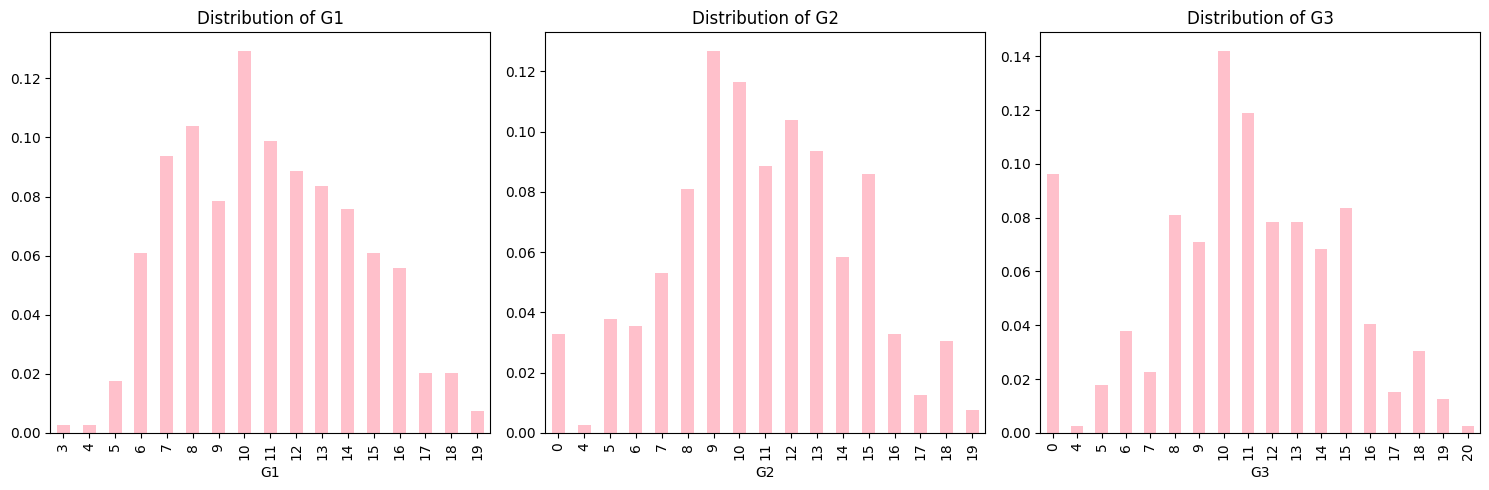

In [194]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
student_data['G1'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=axes[0], color = 'pink')
axes[0].set_title('Distribution of G1')
student_data['G2'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=axes[1], color = 'pink')
axes[1].set_title('Distribution of G2')
student_data['G3'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=axes[2], color = 'pink')
axes[2].set_title('Distribution of G3')

plt.tight_layout()
plt.show()

We can see that there is a majority of 10. This is due to 10 being the treshold for passing. Teachers are improving grades for students to pass.
Overall distribution is looking normal(Gaussian)
Because they look simillar, we will use median of grades for each student to classify, and we will convert 0-20 system to 1-5 grading.
We see the 0's in 2nd and 3rd grade, but decided to predict overall score in school for a student.

<h3>Univariate analysis

---------


Histogram of all features:



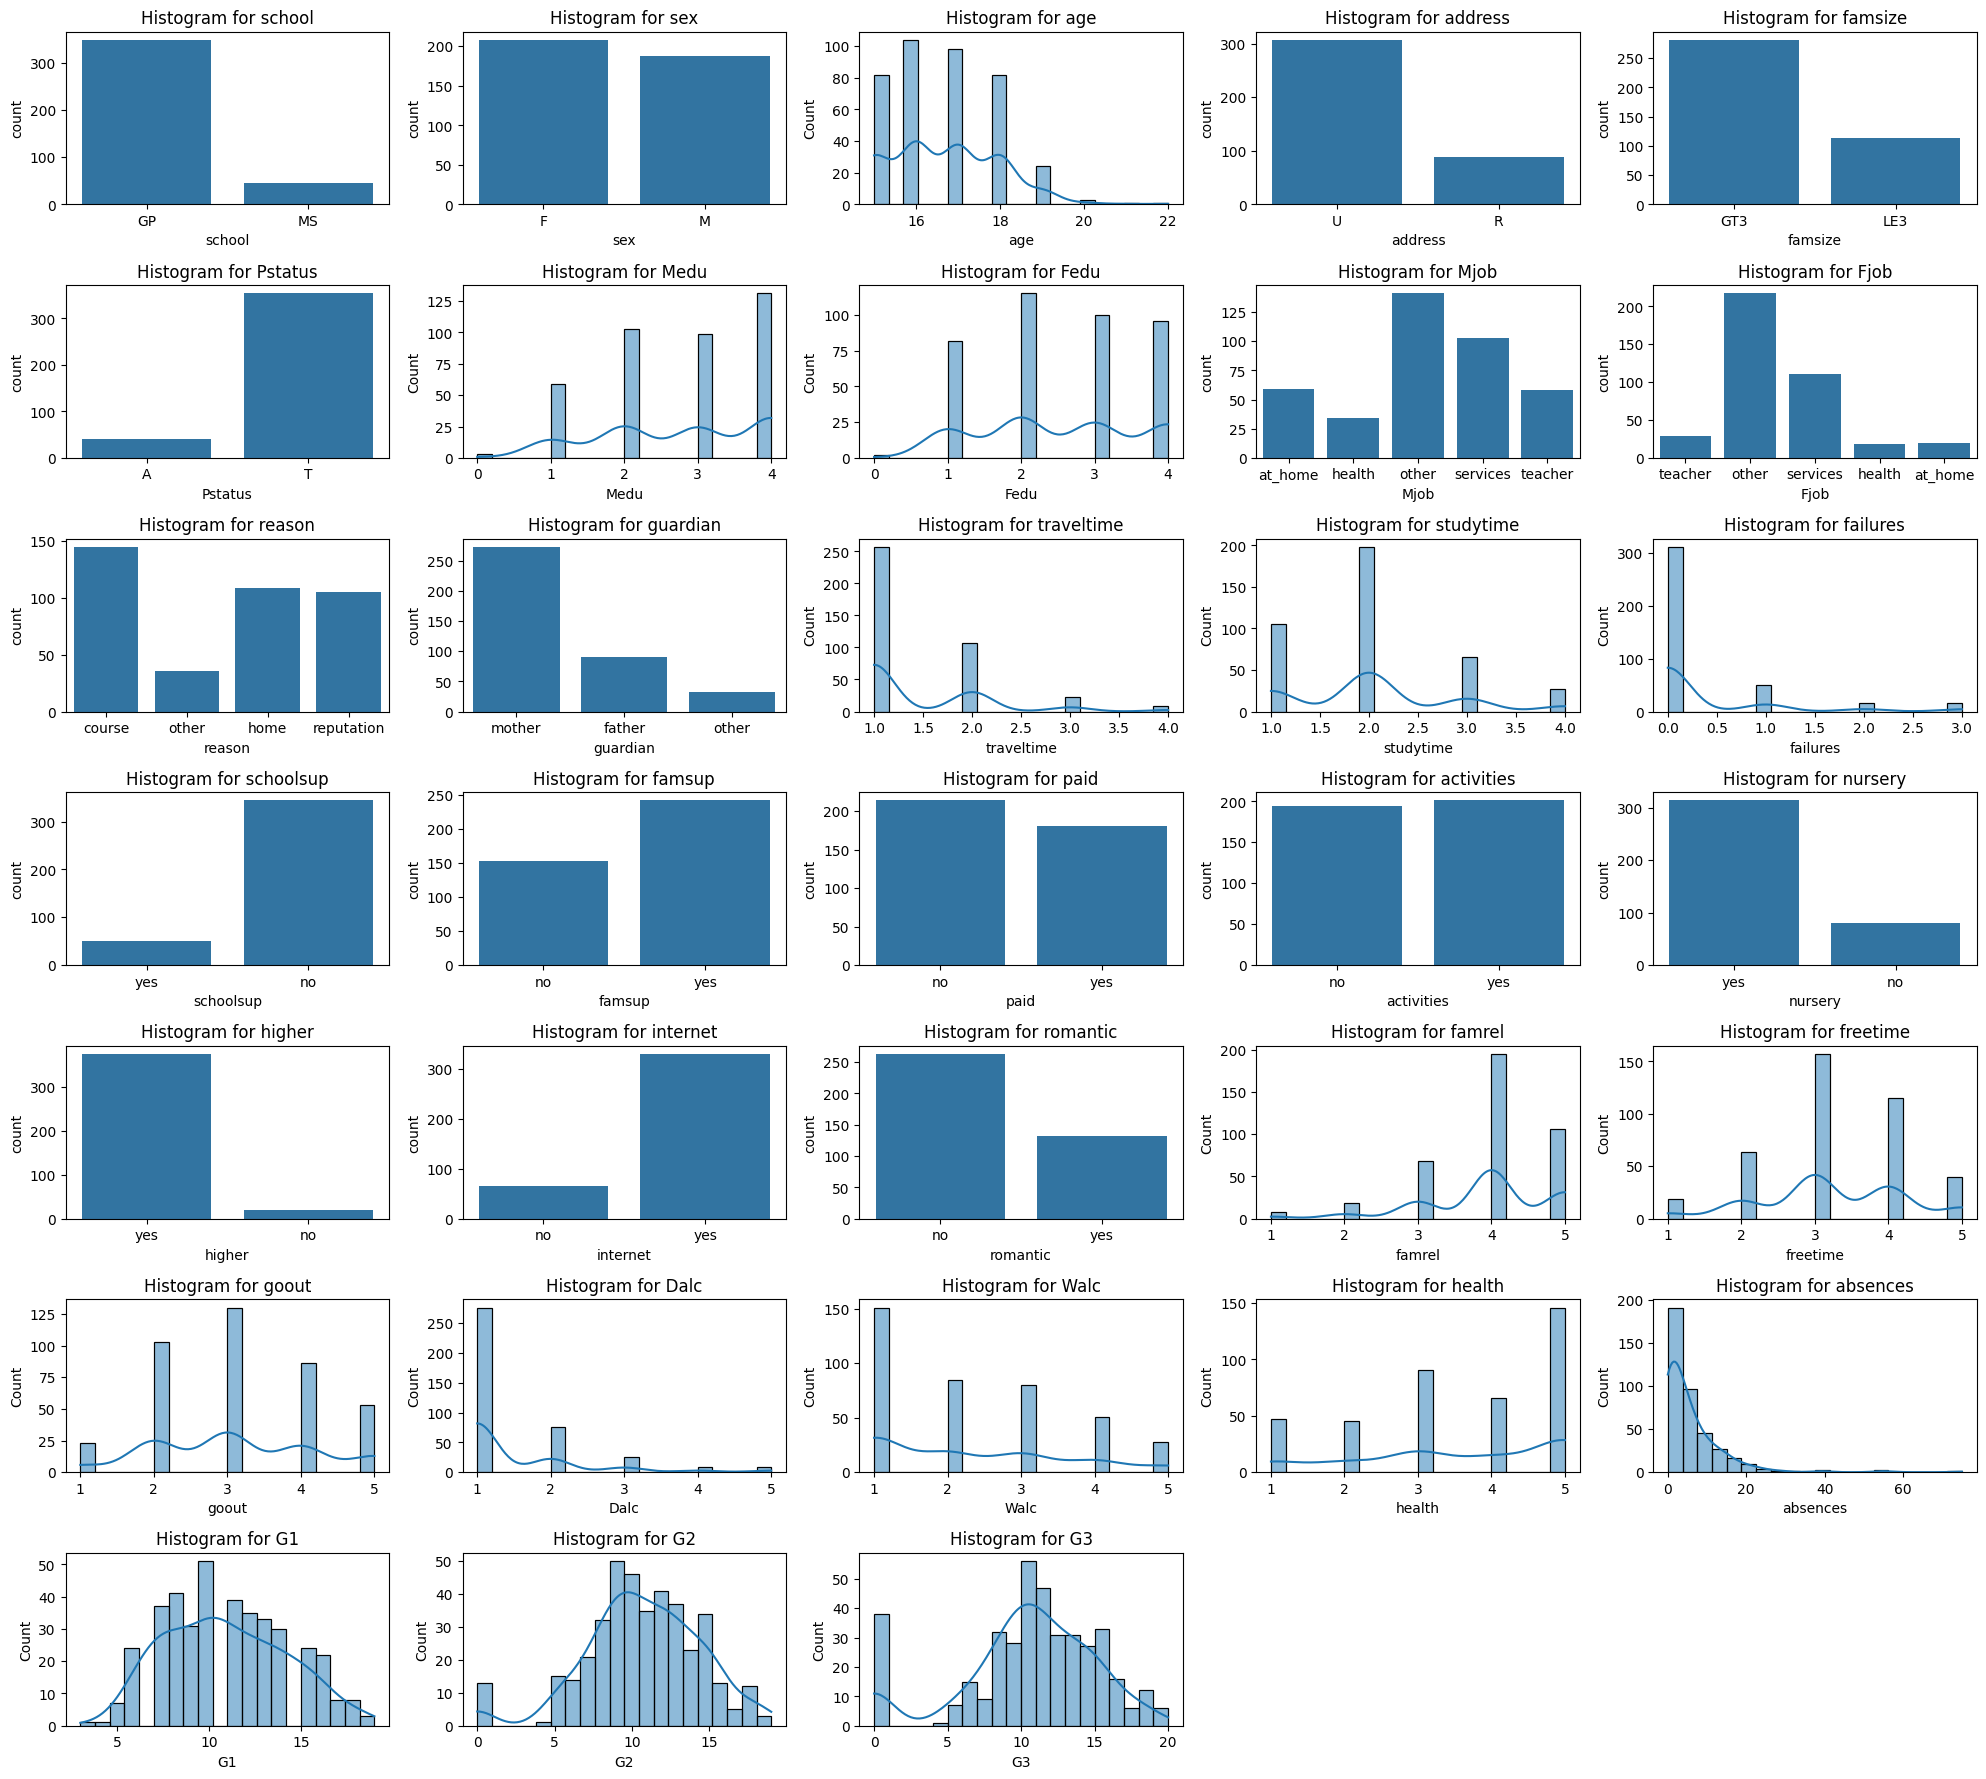

In [195]:
print("\nHistogram of all features:\n")
student_data.columns
plt.figure(figsize = (20,20))
for i, column in enumerate(student_data.columns, 1):
    plt.subplot(8,5,i)
    if student_data[column].dtype == 'object':
        sns.countplot(x=column, data=student_data)
    else:
        sns.histplot(data=student_data[column], bins=20, kde=True) #stat='percent', bins=20
    plt.title(f'Histogram for {column}')
plt.tight_layout()
plt.show()

<h4>Those histograms above provide the overview  of the distribution of the features in the Student Performance Data Set; <br> Some key observations: <br> </h4>
1) School - dataset contains students from two schools: GP and MS, and GP is more represented;<br>
2) Sex - distribution between male(M) and female(F) students is almost equal;<br>
3) Age - distribution shows that most students are between 15 and 19 years old;<br>
4) Address - vast majority of the students live in the urban areas<br>
5) Family Size (famsize)- more students come from smaller families (less than or equal 3 members-LE3) compared to bigger families (greater than 3 members-GT3)<br>
6) Parent's cohabitation status (Pstatus)- majority of the students parents do live together<br>
7) Mother's education (Medu)- most of the students were born to mothers with at least secondry education<br>
8) Father's education (Fedu)- same as Medu<br>
9) Mother's job (Mjob)- many working mothers work in services and in other jobs(unnamed) and fewer as a teahcher, also big percent of mothers are stay at home moms<br>
10) Father's job (Fjob)- most of fathers work in other jobs(unnamed) and in services, smaller number in helthcare and as a teahcers and not many of them are stay at home dads<br>
11) Reason to choose this school - most of the students chose their school because of the provided courses<br>
12) Student's guardian - vast majority of the students have their mom as the guardian<br>
13) Home to school travel time - most of the students have a short commute smaller than 10 minutes<br>
14) Weekly study time - large portion of students spend between 2 and 5 hours per week on study time<br>
15) Number of past class failures - majority of students have zero academic failures<br>
16) Extra educational support  (schoolsup)- most of the students do not recieve extra educational support <br>
17) Family educational support (famsup)- most of the students do recieve support from their families<br>
18) Extra paid classes within the course subject (paid)- students going to paid classess and the ones that are not are distributed almost evenly<br>
19) Extra-curricular activities (activities)- students attending the extra-curricular activities and the ones that are not are distributed almost evenly<br>
20) Attended nursery school (nursery)- majority of the students have attended the nursery<br>
21) Wants to take higher education (higher)- vast majority of the students wants to continue studies in highschool<br>
22) Internet access at home (internet)- vast majority of the students have the access ti the internet<br>
23) In a romantic relationship (romantic)- about 66% of students are not romantically involved<br>
24) Quality of family relationships (famrel)- most of the students have very good family relations<br>
25) Free time after school - students seem to have moderate levels of free time<br>
26) Going out with friends (goout)- students go out regularly, though these are somewhat evenly distributed across the different levels<br>
27) Workday alcohol consumption (Dalc)- Daily alcohol consumption is generally low, with most students having lower levels of consumption.<br>
28) Weekend alcohol consumption (Walc)- Weekend alcohol consumption is generally low, but higher than the daily one, with most students having lower levels of consumption.<br>
29) Current health status - most of the students rate their health as very good or good<br>
30) Number of school absences - vast majority of the students have zero absences<br>
31) Grades (G1,G2,G3) - majority of the students get the passing grade, with the highest occurences of grade 10<br>


<h3>Bivariate Analysis (Two variables-feature vs target)

---------------


Histogram of categorical features against grades:



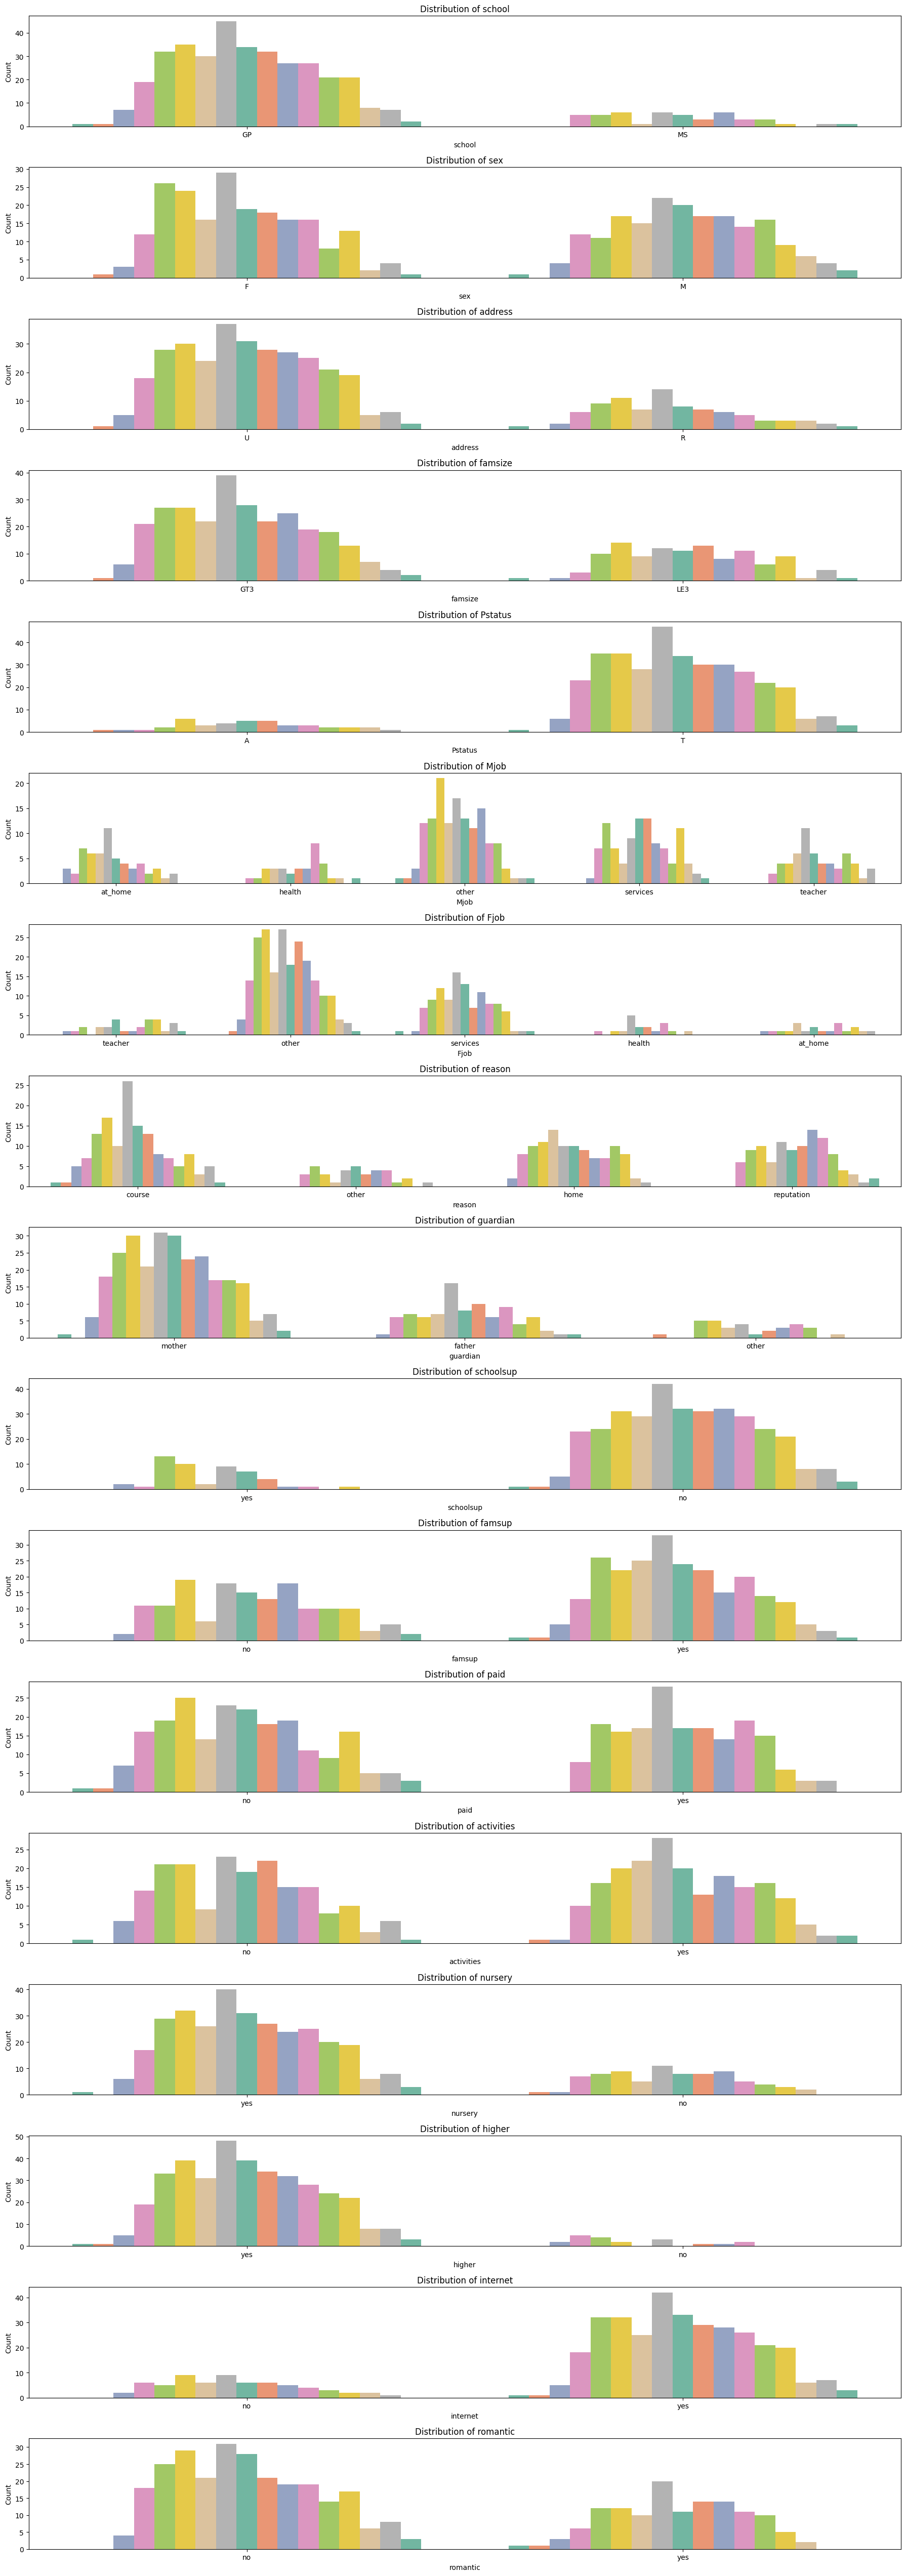


Boxplot of numerical features against grades:



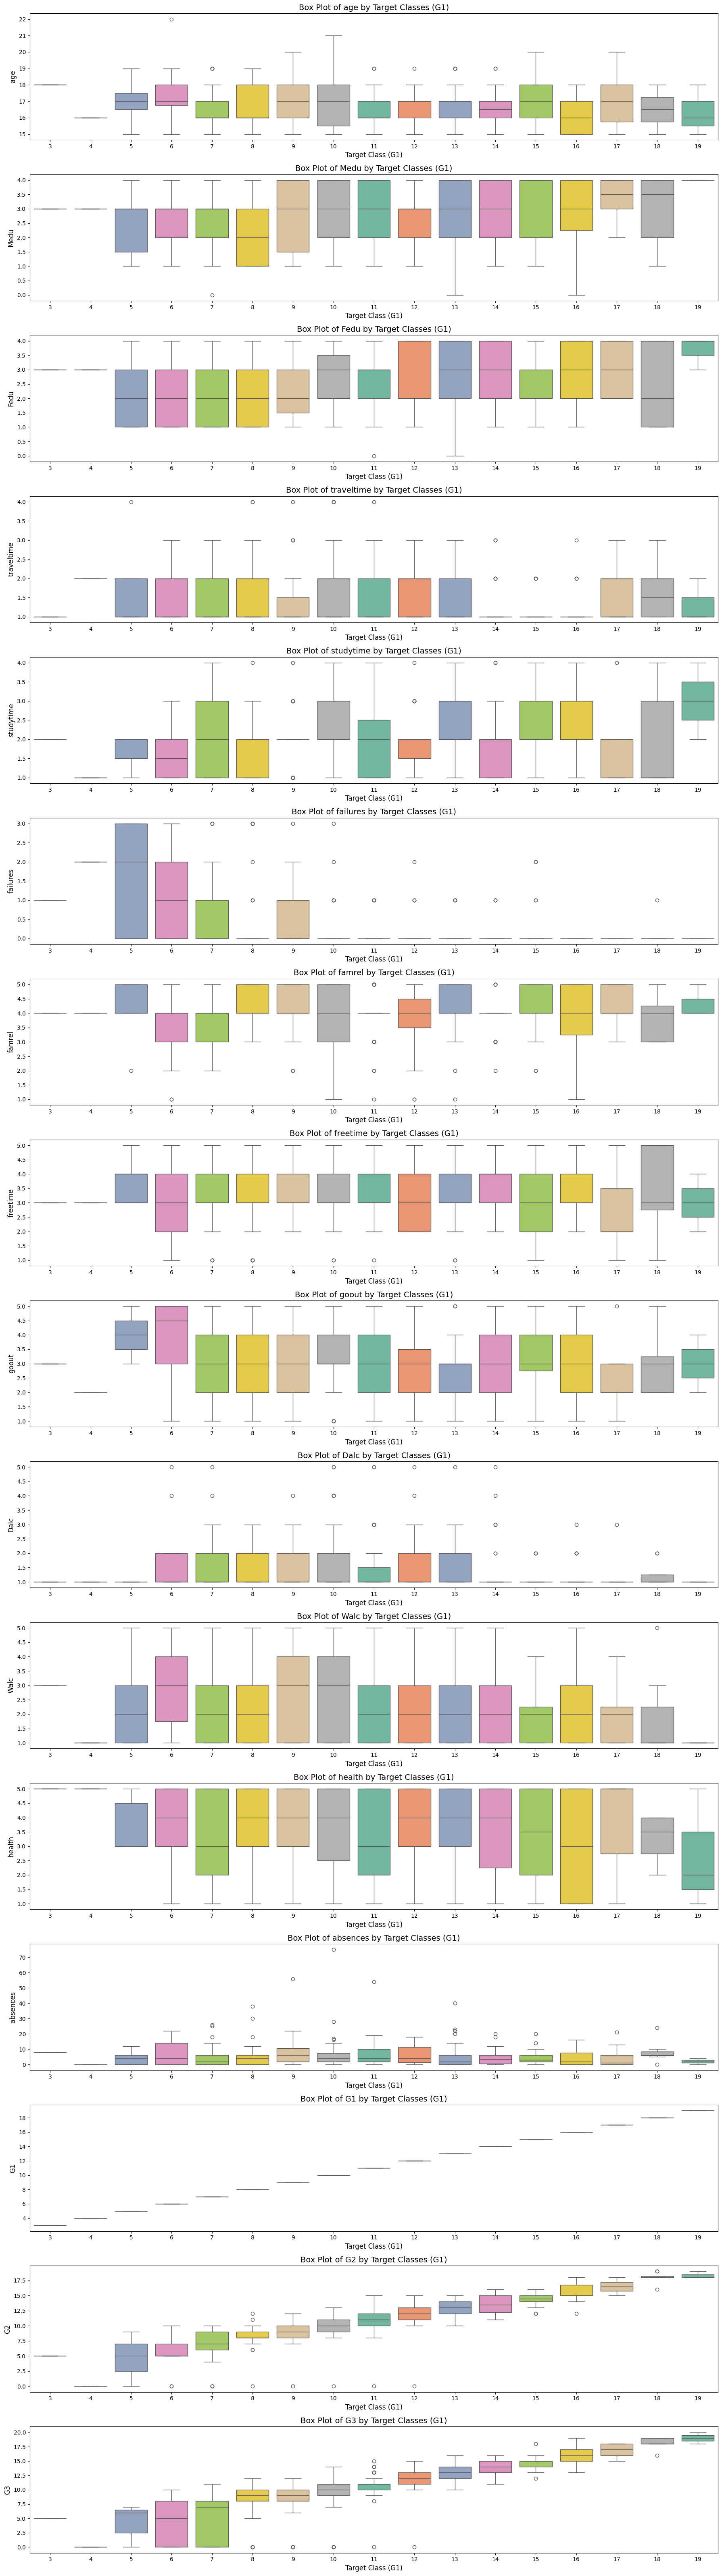

In [196]:
categorical = [column for column in student_data.columns if student_data[column].dtype == 'object']
numerical = [column for column in student_data.columns if student_data[column].dtype in ['int64', 'float64']]
print("\nHistogram of categorical features against grades:\n")

# Categorical features plot
plt.figure(figsize=(18, len(categorical) * 3)) 
for i, column in enumerate(categorical, 1):
    plt.subplot(len(categorical), 1, i)  
    sns.countplot(x=column, data=student_data, hue='G1', palette='Set2')
    plt.title(f'Distribution of {column}', fontsize=12)
    plt.xlabel(column, fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.legend([],[], frameon=False) 

plt.tight_layout()
plt.show()

print("\nBoxplot of numerical features against grades:\n")

plt.figure(figsize=(18, len(numerical) * 4)) 
for i, column in enumerate(numerical, 1):
    plt.subplot(len(numerical), 1, i)
    sns.boxplot(x='G1', y=column, data=student_data, palette='Set2', hue='G1') 
    plt.title(f'Box Plot of {column} by Target Classes (G1)', fontsize=14)
    plt.xlabel('Target Class (G1)', fontsize=12)
    plt.ylabel(column, fontsize=12)    
    plt.legend([],[], frameon=False) 


plt.tight_layout()
plt.show()


<h5>The Bivariate Analysis allows us to compare how the different features relate to the target. The histograms and box plots show the relationships and potential patterns between features. For categorical variables, we use histograms to observe the distribution of grades, providing insights into how different groups perform. For numerical variables, the box plots show how grades vary across different feature values, giving a clear view of trends and outliers within the data. It helps us understand which features might be important predictors of student performance.</h5>

<h3>Multivaraite analysis

----------------


Correlation heatmap:



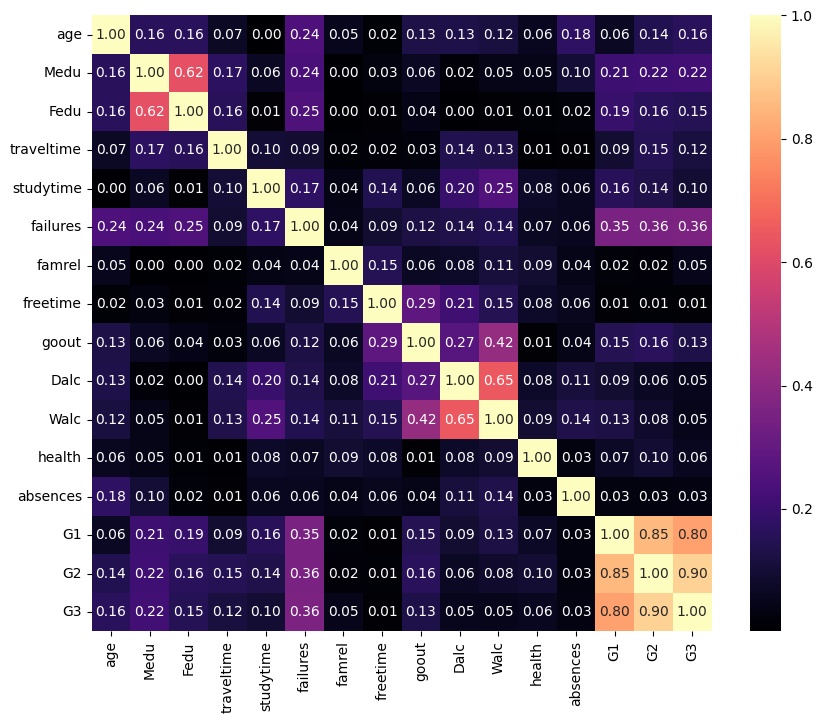

In [197]:
print("\nCorrelation heatmap:\n")
plt.figure(figsize=(10,8))
sns.heatmap(abs(student_data[student_data.columns[student_data.dtypes == np.int64]].corr()), cmap='magma',annot=True, fmt=".2f")
plt.show()

# sns.pairplot(student_data, hue='G1')

<h5>The correlation heatmap shows relationships between numerical features in the Student Performance Data Set. By examining the correlation values, we see how strongly two variables are related. For instance, attributes like <b>G1, G2, and G3</b> have high correlations with each other, which makes sense since <b>they represent grades from different periods of the same students</b>. Another notable correlation is between <b>weekday and weekend alcohol consumption</b>, indicating that students who consume alcohol during the week tend to also consume it on weekends. Additionally, the strong correlation between <b>mother's and father's education</b> suggests that people often form relationships with partners who have a similar level of education.</h5>

<h3>Feature Engeineering

-------------------

In [203]:
student_data = pd.read_csv("student_data.csv")
print(student_data.columns)
print(student_data.shape)

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')
(395, 33)


In [204]:
student_data['Grades'] = student_data[['G1', 'G2', 'G3']].mean(axis=1)
# Binarize the grades into 5 bins
bins = [0, 9, 13, 15, 17, 20]
labels = [1, 2, 3, 4, 5]
student_data['target'] = pd.cut(student_data['Grades'], bins=bins, labels=labels, right=True)
student_data.drop(columns=['G1', 'G2', 'G3', 'Grades'], inplace=True)

Since we are predicting the overall grade of the student's we take all three of them (G1,G2&G3) and calculate their mean. After obtaining their average for each of the students we bin them into categories from 1 to 5 based on the treshold. This bins represent the grade (in polish grading system), making it easier to classify the students into the groups for better prediction and data analysis. After creating that target variable, we drop the columns with G1,G2,G3 since they are no longer needed. 

In [205]:
student_data.drop(columns=['age', 'traveltime', 'freetime'], inplace=True)

Since som of the values were irrelevant (or almost irrelevant) we dropped them. <br> 
Removing these less relevant features helps simplify the model and may improve its performance

In [206]:
student_data.head()

school sex address famsize Pstatus  Medu  Fedu     Mjob      Fjob  reason  \
0     GP   F       U     GT3       A     4     4  at_home   teacher  course   
1     GP   F       U     GT3       T     1     1  at_home     other  course   
2     GP   F       U     LE3       T     1     1  at_home     other   other   
3     GP   F       U     GT3       T     4     2   health  services    home   
4     GP   F       U     GT3       T     3     3    other     other    home   

   ... higher  internet  romantic famrel goout Dalc Walc health absences  \
0  ...    yes        no        no      4     4    1    1      3        6   
1  ...    yes       yes        no      5     3    1    1      3        4   
2  ...    yes       yes        no      4     2    2    3      3       10   
3  ...    yes       yes       yes      3     2    1    1      5        2   
4  ...    yes        no        no      4     2    1    2      5        4   

  target  
0      1  
1      1  
2      1  
3      3  
4      1  

[5 rows x 28 columns]

<h3>Splitting the dataset

------

In [207]:
# Split the data
X = student_data.drop(columns=['target'])
y = student_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 https://medium.com/@sahin.samia/scikit-learn-pipelines-explained-streamline-and-optimize-your-machine-learning-processes-f17b1beb86a4

<h3>Sklearn pipeline preprocessing

In [223]:
#pipeline doesnt have threshold encoding by default, so im making my own transformer
def binarize_absences(X):
    threshold = 12  # Define your threshold
    return (X > threshold).astype(int)


ordinal_features = ['Medu', 'Fedu', 'studytime', 'failures', 'goout', 'Dalc', 'Walc', 'health', 'famrel']  # Numeric ordinal features
categorical_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'reason', 'guardian', 
                        'Mjob', 'Fjob']  # Include other categorical features as needed
binary_features = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'romantic', 'internet']  # Binary features
binary_threshold_feature = ['absences']


#create preprocessing pipeline part. encoding, binarization
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_features),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('binary', OneHotEncoder(handle_unknown='ignore'), binary_features),
        ('binarize', FunctionTransformer(binarize_absences, validate=False), binary_threshold_feature)
    ],
    remainder='passthrough'  # Leave other features untouched
)

#Create feature selection ANOVA F-score classifier. hyperparameter=10
feature_selection = FeatureUnion(
    transformer_list=[
        ('select_best', SelectKBest(score_func=f_classif, k=15))
    ]
)

# Create the pipeline, add predictive model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', RandomForestClassifier(random_state=42))  # set 42 for reproducibility
])

# Fit the pipeline on the data (X, y)
pipeline.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Medu', 'Fedu', 'studytime',
                                                   'failures', 'goout', 'Dalc',
                                                   'Walc', 'health',
                                                   'famrel']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['school', 'sex', 'address',
                                                   'famsize', 'Pstatus',
                                                   're...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['schoolsup', 'famsup',
                                                   'paid', 'activities',
                                                   'nursery', 'higher',
                                                   'romantic', 'internet']),
                                                 ('binarize',
                                                  FunctionTransformer(func=<function binarize_absences at 0x0000019B5FEE5510>),
                                                  ['absences'])])),
                ('feature_selection',
                 FeatureUnion(transformer_list=[('select_best',
                                                 SelectKBest(k=15))])),
                ('classifier', RandomForestClassifier(random_state=42))])

Here the pipeline is created. <br>
First it processess the data by encoding ordinal, cathegorical and binary features; it uses ANOVA F-score to select the top 15 features and applies a <b>Random forest classifier</b> to make the predictions- to predict what grade the student will get based on many features.

<h3>Explainer

-------------

In [224]:
exp = dx.Explainer(pipeline, X, y)

Preparation of a new explainer is initiated

  -> data              : 395 rows 27 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 395 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x0000019B36990310> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.399, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = 0.42, mean = 1.69, max = 4.99
  -> model_info        : package sklearn

A new explainer has been created!


In [226]:
exp.model_parts()

In [227]:
exp.model_parts().plot()

<h5> Here the dropout loss tells us how much the performance of the model decreases when the given feature is permuted (modified). The higher dropout loss means that the given feature is more important. </h5>
From the exp.model_parts() and exp.model_parts().plot() and we see that the most important feature in the dataset is the mother's job, followed by the father's job and their education (Fedu and Medu), and rason why student chose their school. They have the highest dropout loss, indicating that they have actually the biggest impact on predicting student's performance.

In [213]:
exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 27/27 [00:03<00:00,  8.90it/s]


<h3>Representative samples for each grade</h3>


----------

<h5> The representative samples are chosen to show examples of students who received each grade. These samples help us understand the patterns associated with different grades.<br> They are selected from each target value, so the grades 1, 2, 3, 4, 5- to capture typical examples of students in each group. <br> This allows us to summarize the entire dataset by focusing on key points that represent the students' grades effectively.</h5>

In [214]:
representative_samples = find_representants(student_data, number_of_clusters=3, pipeline=pipeline)
representative_samples = dict(sorted(representative_samples.items()))
print(f"The students' indexes that are the representative ones for their grade (representative samples): \n{representative_samples}")


The students' indexes that are the representative ones for their grade (representative samples): 
{1: [90, 128, 264], 2: [181, 344, 50], 3: [302, 291, 348], 4: [36, 59, 226], 5: [8, 107, 42]}


In [215]:
#number_of_graphs = len(sample)
number_of_graphs = 3
for grade, sample_id in representative_samples.items():
    print(f"Representative sample for a grade {grade}: {sample_id}")
    for i in range(0, number_of_graphs):
        print('----------------------------------------------------------------------------------------------------------------------------------------------')
        print(f'SHAP Summary Plot for a sample with index {X.index[sample_id[i]]}')
        exp.predict_parts(X.iloc[sample_id[i]], type='shap').plot()
    
    

Representative sample for a grade 1: [90, 128, 264]
----------------------------------------------------------------------------------------------------------------------------------------------
SHAP Summary Plot for a sample with index 90


KeyboardInterrupt: 

<h4>Checking model performance


----------

              precision    recall  f1-score   support

           1       0.94      0.94      0.94        32
           2       0.95      0.91      0.93        22
           3       0.88      1.00      0.93        14
           4       0.86      0.75      0.80         8
           5       1.00      1.00      1.00         3

    accuracy                           0.92        79
   macro avg       0.92      0.92      0.92        79
weighted avg       0.92      0.92      0.92        79



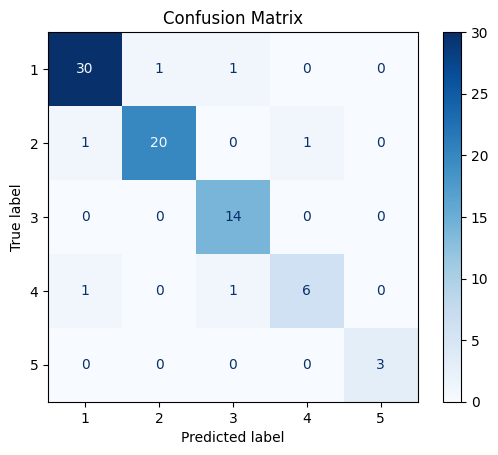

In [228]:
y_pred  = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)
print(report)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

<h2>Summary</h2>

----------

<h3>Based on the confusion matrix and classification report, the model has achieved an overall accuracy of <b>92%</b> on the test data</h3>

1. <b>Grade 1</b> (students with the lowest grade range), the model performed very well, with a <b>94% precision<b> and <b>94% recall</b>; that means that the model accurately predicted most instances and made very few mistakes.<br>
2. <b>Grade 2</b> it also shows strong results, with a <b>95% precision</b> and <b>91% recall</b> telling us that that while the model was mostly accurate, there were a few misclassifications- the model predicted the wrong grade for the student.<br>
3. <b>Grade 3</b> was predicted extremely well, with the model correctly identifying all instances of this class (<b>100% recall</b>).<br>
4. <b>Grade 4</b> here the model struggled a bit, because the recall dropped to <b>75%</b>, meaning that it has predicted wrong grades for a few students.
5. <b>Grade 5</b> had perfect results across the board, with <b>100% precision</b>, recall, and F1-score, though it's worth noting that there were only a few examples of students who recieved this grade in the test data.

-----------